# 2. Recommendation System
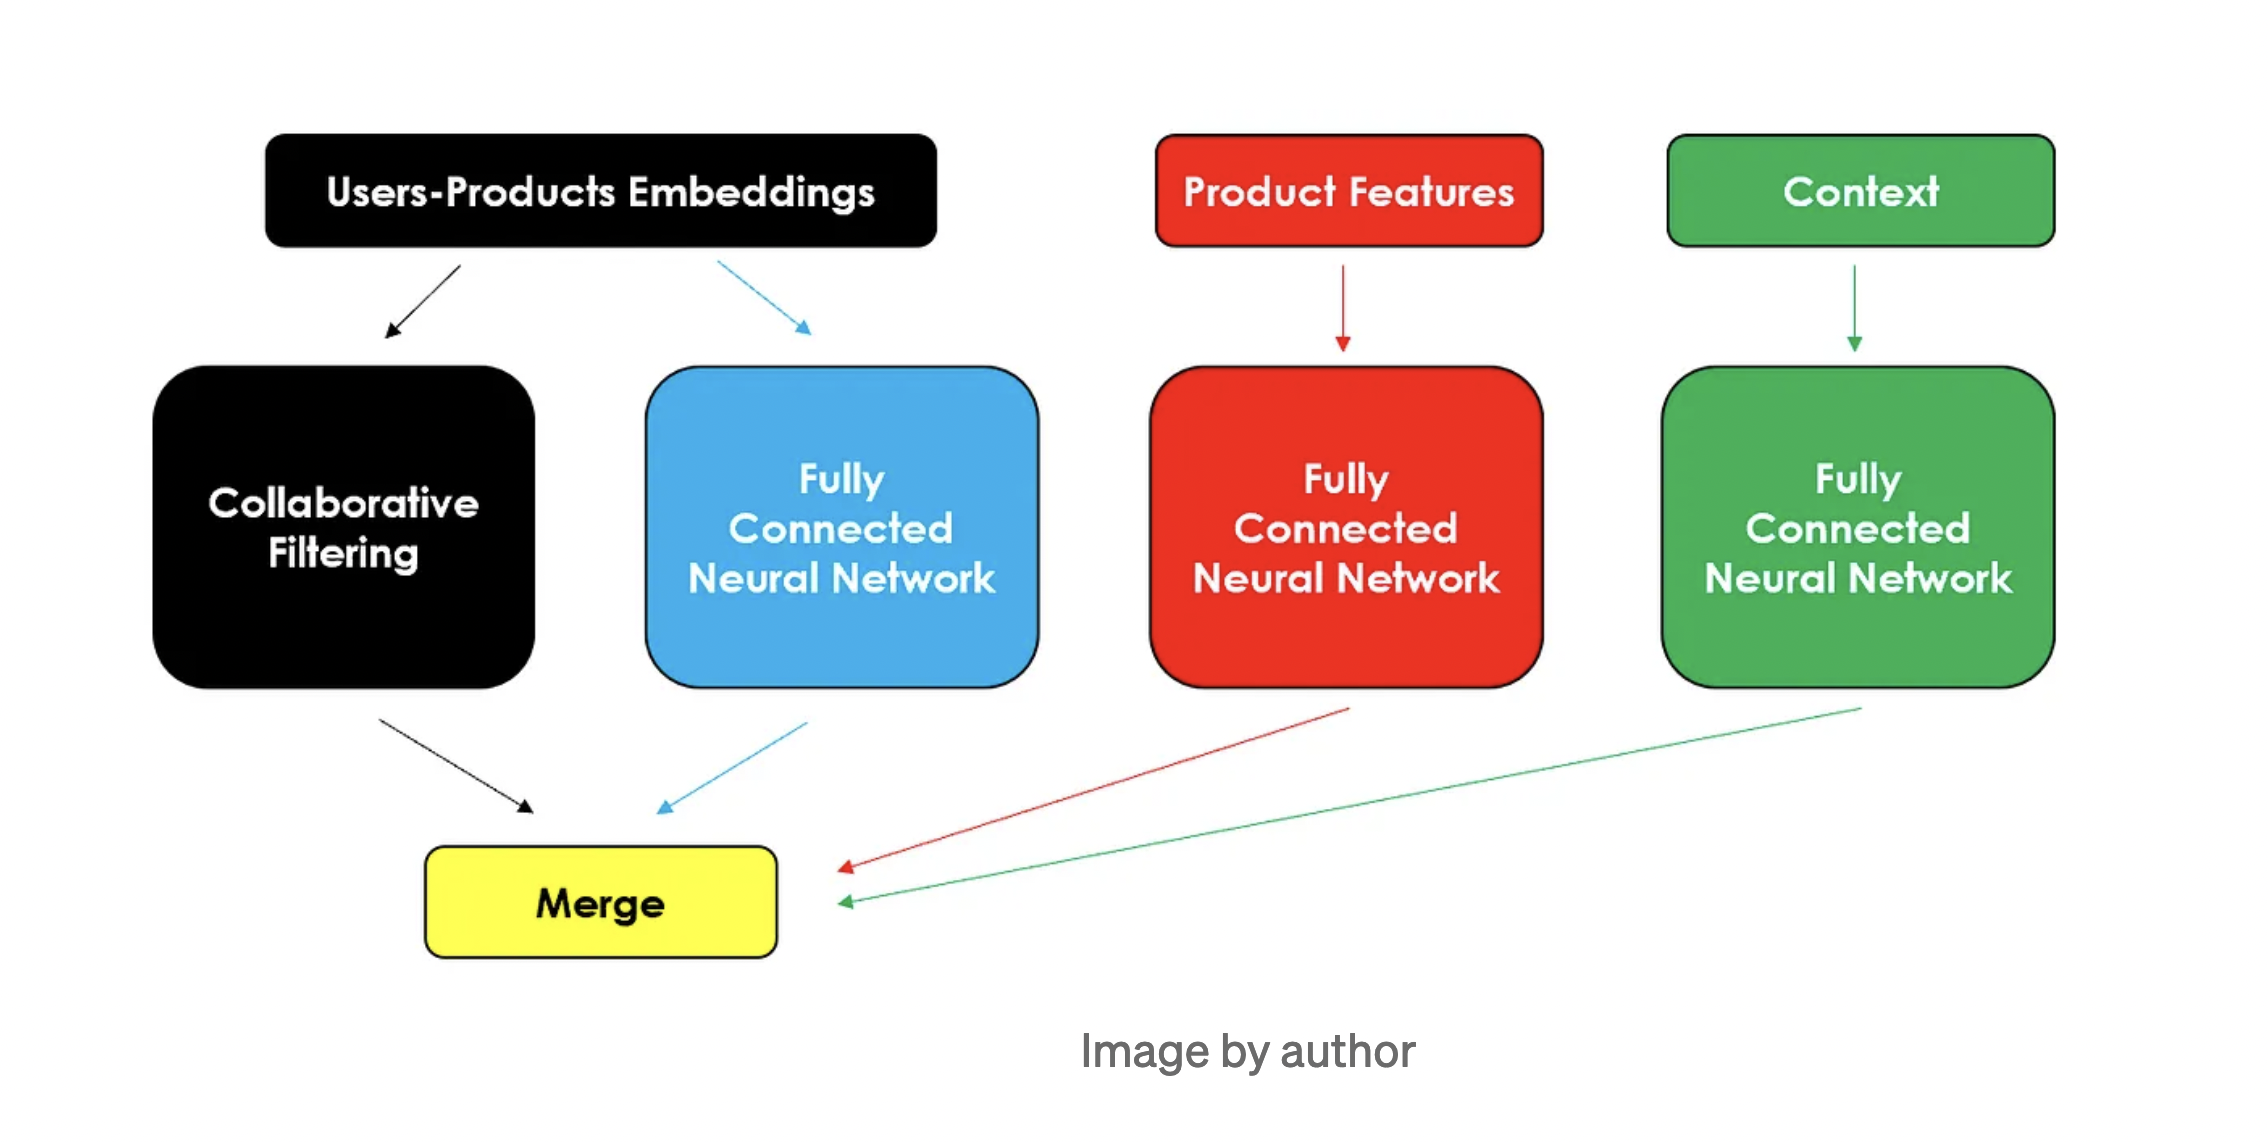

###### In order for our recommendation system to be dynamic taking into consideration progress, preferance and context, the best way is to implement a hybrid context aware recommendation system which will benefit from both content based recsys and collaberative based recsys as can be seen in the figure above.



In [165]:
## Important imports for interactions model
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity
import random
from datetime import datetime, timedelta


## 2.1 Making History!

###### Since we are dealing with mock data all our users appears as "new"  and so we suffer from the cold start problem. The hybrid architechture we will see in 2.2 helps us to deal with it but it doesn't seem enough as we want a dynamic system! So to deal with it for now we will "generate" interactions/history by making smart guesstimate.
Later on in 3 we will discuss the feedback system which is linked with the history we are creating and we will also discuss the data collection and the evolution over time but for now let's make history!

In [202]:
content = pd.read_csv("content_model.csv")
learner = pd.read_csv("datallm_mock_data_v3.csv")
learner_english = learner[learner["Language"]=="English"]
learner_english.drop(columns = ["Unnamed: 0"], inplace=True)
learner_english

<ipython-input-202-b0adde611038>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  learner_english.drop(columns = ["Unnamed: 0"], inplace=True)


,user_id,username,Age,Language,Proficiency,Objective,Learning Type,Tell us about yourself
0,AR1E51,vishal_12,24-35,English,Intermediate,Travel,Self Study,Business Analyst
3,LPJ5VM,Klausen,65+,English,Advanced,Career,Mix,I am a professional academic researcher and wr...
4,wK9Nxv,M_4buz,Under 18-,English,Begginer,Career,Mix,I have a Guinea pig and I am watching a movie.
6,cv8stp,bandar04,18-24,English,Intermediate,Career,Self Study,Hobbies :Gardening
8,sjfPRZ,gamengd,18-24,English,Begginer,School/Uni,Self Study,I'm a student
...,...,...,...,...,...,...,...,...
4991,2CtVzF,Samu,35-45,English,Intermediate,Social,Live Class,"I am very polite person, I like to make new fr..."
4992,2UYT4F,Krishna22,35-45,English,Advanced,Career,Self Study,"Honesty, Loyalty and Integrity."
4993,hN29Ej,LangLearner,56-65,English,Intermediate,Other,Self Study,To improve my English
4994,24ER6V,Javan153,18-24,English,Intermediate,School/Uni,Live Class,Ho


In [167]:
content

,lesson_title,cefr_level,uuid,grammar_tags,vocabulary_tags,learning_language,content_type
0,Interrogatives,C1,a4845f1a-1566-41b4-bc09-38801e55ecc3,pronoun:interrogative,"phones, emotions_states",English,unit
1,Absolute superlative,B1,e13d14e9-7a6b-497a-a267-2109ce1e747f,"adjective:absolute_superlative, verb:future_tense","space, nations_geography, outdoors, locations_...",English,grammar_card
2,Prepositions and pronouns,A2,50a4cd70-dd2c-4078-98f2-68367d800545,"preposition, pronoun:impersonal","non_understanding, week_dates, hobbies_games, ...",English,live_class
3,Progressive aspect,B1,25a52fc4-4cb5-41ed-a9a1-bd9c25fef592,verb:progressive_aspect,"materials, university_academia, emotions_states",English,self_study
4,Comparatives,A1,8b5b57f2-d5cc-4cdd-a83e-23735b6106da,"adjective:comparative, adverb","public_transit_trains, locations_directions",English,grammar_card
...,...,...,...,...,...,...,...
195,Infinitive,C1,b7d37fbb-e38d-47c3-b551-c457235af558,"verb:infinitive, number_ordinal, interjection","politics, nature_landscapes, senses, cooking_t...",English,live_class
196,Informal pronoun,C2,f5e0d4d9-92ce-4cbe-b1bd-a8ca4e0d0fe7,"pronoun:informal_pronoun, noun:definite_form",measurement_quantities,English,live_class
197,Conditional mood,C2,eb58ac5d-2f40-43d0-af13-31e2d7f408fc,"verb:conditional_mood, pronoun:interrogative, ...","outdoors, groceries_fruits_vegetables, internet",English,self_study
198,Superlative,B2,7094615e-b4ab-4b88-9ee8-38476434fcb2,adverb:superlative,"shapes, work_life, shopping, emotions_states",English,unit


In [169]:
### Scehma of interactions dataset
# Adding a date will be important to keep track of progress
# IDs to compare users vs content
# rating will be the target value as users will rate out of 10 ---> See part 3
# from all level_fb, type_fb, vocabulary_fb, grammar_fb will be an indicator
#that users will submit along with the rating to indicate what they liked/didnt like about the course
# THe rest of the fields will contain product features and user features

interactions = pd.DataFrame(columns=['date','user_ID','content_ID','rating','level_fb','type_fb','vocabulary_fb', 'grammar_fb', 'cefr_level', 'content_type','age','proficiency','objective','learning_type' ])
interactions

,date,user_ID,content_ID,rating,level_fb,type_fb,vocabulary_fb,grammar_fb,cefr_level,content_type,age,proficiency,objective,learning_type


##### The cell below contains important functions that will be used to not only generate timestamps but also use the bert embeddings of all the text features we have, to capture semantic similarity

In [170]:

import random
from datetime import datetime, timedelta

def generate_random_dates(n):
    start_date = datetime(2023, 1, 1)
    #end_date = datetime(2023, 12, 31)
    random_ints = [random.randint(0, 365) for _ in range(n)]
    random_ints.sort()
    dates = [start_date + timedelta(days=random_days) for random_days in random_ints]
    return dates
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embedding_vocab(text):
    text = text.vocabulary_tags
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
content['vocab_embeddings'] = content.apply(get_bert_embedding_vocab, axis = 1)

def get_bert_embedding_grammar(text):
    text = text["grammar_tags"]
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
content['grammar_embeddings'] = content.apply(get_bert_embedding_grammar, axis = 1)
def get_bert_embedding_about(text):
    text = text["Tell us about yourself"]
    text = str(text)
    if text=='nan':
      text=""
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
learner_english['about_embeddings'] = learner_english.apply(get_bert_embedding_about, axis = 1)
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
objective_embeddings = []
for i in learner_english.Objective.unique():
  objective_embeddings.append(get_bert_embedding(i))

In [176]:
learner_english.Objective.unique()

array(['Travel', 'Career', 'School/Uni', 'Social', 'Hobby', 'Other',
       'Brain'], dtype=object)

###### This is the part where we create the interactions we will kick start our history by randomly selecting between 0-10 courses and evaluating them as choices based on user, content, and of course any specific request using embeddings

In [104]:
obj_list = ['Travel', 'Career', 'School/Uni', 'Social', 'Hobby', 'Other','Brain']
count = 0
about_embeddings = []
grammar_embeddings = []
vocabulary_embeddings = []
for user in learner_english.to_dict("records"):
  #print(user)
  temp = np.random.randint(10)
  cand = content.sample(temp)
  dates = generate_random_dates(temp)
  user_level = user["Proficiency"]
  user_type = user["Learning Type"]
  user_objective = user["Objective"]
  age=user["Age"]
  about_emb = (user['about_embeddings'])
  contents_id=(cand.index)
  for k in range(temp):
    content_id = contents_id[k]
    i=cand.iloc[k]
    level= (i['cefr_level'])
    c_type = i['content_type']
    voc_emb = (i['vocab_embeddings'])
    gram_emb = (i["grammar_embeddings"])


   ### The most important part especially at the beggining is to choose an appropriate level as basic recommendations
   ### So we evaluate the user level vs cefr_level. Besides that its also very important to select the right content for
   ### The preferences of people easpecially if they are not in a mix subscription

    if ((user_level == "Begginer" and level[0]!='A') or (user_level=="Intermediate" and level[0]!='B') or (user_level=="Advanced" and level[0]!='C')):
      lr=0 ### not appropriate level
    else:
      lr = 1 ## appropriate level
    if ((user_type=="Self Study" and c_type == "live_class") or (user_type=="Live Class" and c_type == "self_study")):
      lc = 0 ## not appropriate content
    else:
      lc = 1 ## appropriate content

    ### After this we can only guess on vocab and grammar, based on cosine similarity.
    median_similarity = np.median(cosine_similarity(objective_embeddings,[voc_emb]))
    user_similarity = cosine_similarity([objective_embeddings[obj_list.index(user_objective)]],[voc_emb])
    if user_similarity >= median_similarity:
      lv = 1
    else:
      lv = 0
    lg = int(random.random() > 0.7)
    rating = lr * 3 + lc * 3 + lv * 2 + lg * 2

    ### we add everything to the records


    interaction = pd.DataFrame({"date": dates[k], "user_ID":[count], "content_ID":[content_id], "rating": [rating],
                                "level_fb": [lr],"type_fb":[lc], "vocabulary_fb":[lv], "grammar_fb":[lg], "cefr_level":level,"content_type":c_type,
                                 "age":age, "proficiency":user_level,"objective":user_objective, "learning_type":user_type})

    interactions = pd.concat([interactions, interaction],ignore_index = True)
    about_embeddings.append(about_emb)
    vocabulary_embeddings.append(voc_emb)
    grammar_embeddings.append(gram_emb)

  count+=1






In [105]:
### Here is the interactions dataset!
interactions

,date,user_ID,content_ID,rating,level_fb,type_fb,vocabulary_fb,grammar_fb,cefr_level,content_type,age,proficiency,objective,learning_type
0,2023-01-16,0,29,3,0,1,0,0,C1,self_study,24-35,Intermediate,Travel,Self Study
1,2023-07-17,0,95,3,0,1,0,0,C1,unit,24-35,Intermediate,Travel,Self Study
2,2023-10-19,0,70,5,0,1,1,0,C1,self_study,24-35,Intermediate,Travel,Self Study
3,2023-11-02,0,164,3,0,1,0,0,A2,self_study,24-35,Intermediate,Travel,Self Study
4,2023-03-24,1,56,8,1,1,1,0,C2,grammar_card,65+,Advanced,Career,Mix
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12808,2023-03-04,2801,156,5,1,0,1,0,B2,self_study,18-24,Intermediate,School/Uni,Live Class
12809,2023-08-18,2801,189,7,0,1,1,1,A2,live_class,18-24,Intermediate,School/Uni,Live Class
12810,2023-12-25,2801,59,5,0,1,1,0,A2,live_class,18-24,Intermediate,School/Uni,Live Class
12811,2023-01-18,2802,69,5,0,1,1,0,A2,unit,18-24,Advanced,Career,Live Class


In [107]:
### And here is the interactions dataset with embeddings
### Uncomment below to try with smaller dataset

embeddings = pd.DataFrame([vocabulary_embeddings, grammar_embeddings, about_embeddings],)
embeddings = embeddings.T.rename(columns={0:"vocabulary_embeddings", 1: "grammar_embeddings",2:"about_embeddings"})
interactions_complete = pd.concat([interactions,embeddings],axis = 1)

'''interactions_1000 = pd.concat([interactions,embeddings],axis = 1)
uncomment below to use the small interactions dataset provided
otherwise use regular workflow


interactions_1000.to_csv("interactions_small.csv")

interactions_comleteto_csv("interactions_modek.csv")
interactions_1000= pd.read_csv("interactions_small.csv")'''




##### That's it for history now that we have a template for a target and training we can make it dynamic and improve the data,

# 2.2 Hybrid Recommendation system

In [18]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.8 MB/s eta 0:00:00


In [108]:
### generic imports for ML developement
import re
import tensorflow as tf
from datetime import datetime## for plotting
import matplotlib.pyplot as plt
import seaborn as sns## for machine learning
from sklearn import metrics, preprocessing## for deep learning
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, utils
import category_encoders as ce

##### The first step is to preprocess to get the data cleaned, scaled, encoded and split

In [203]:
##Preparing training dataset
df = interactions_complete
### Functions needed to fix dataframe






###

def pipeline(train):
  ## As distance matters here we need these functions to have the right encoding
  ## age fixer to have under 18- category recognized as ordinal 0
  def age_fixer(row):
    temp = row['age']
    if temp == "Under 18-":
      return "18-"
    else:
      return temp
## Custom ordinal encoder as begginer is ordinal 0 and so on
  def proficiency_encoder(row):
    temp = row['proficiency']
    if temp=="Begginer":
      return 0.0
    elif temp=="Intermediate":
      return 1.0
    else:
      return 2.0

  # Scaling Target rating
  scaler = preprocessing.StandardScaler()

  ### Encoders

  ##### Ordinal Encoders for sequential values
  cefr_encoder = preprocessing.OrdinalEncoder()
  age_encoder = preprocessing.OrdinalEncoder()
  date_encoder = preprocessing.OrdinalEncoder()

  ##### One hot encoders for pure categorical values
  content_type_encoder = ce.OneHotEncoder()
  objective_encoder = ce.OneHotEncoder()
  learning_type_encoder = ce.OneHotEncoder()

  #### Applying Encoders and transformation functions for preprocessing pipeline
  train["rating"] = scaler.fit_transform(train[["rating"]])
  train['cefr_level'] = cefr_encoder.fit_transform(train[['cefr_level']])#
  train['proficiency'] = train.apply(proficiency_encoder, axis =1)
  train_encoded = content_type_encoder.fit_transform(train['content_type'])
  train = train.drop(columns=['content_type'])
  train = pd.concat([train, train_encoded], axis=1)
  train['age'] = train.apply(age_fixer,axis = 1)
  train['age']= age_encoder.fit_transform(train[['age']])
  train['date'] = date_encoder.fit_transform(train[['date']])
  train_encoded = objective_encoder.fit_transform(train['objective'])
  train = train.drop(columns=['objective'])
  train = pd.concat([train, train_encoded], axis=1)
  train_encoded = learning_type_encoder.fit_transform(train['learning_type'])
  train = train.drop(columns=['learning_type'])
  train = pd.concat([train, train_encoded], axis=1)
  train = train.sort_values("date")
  return train

train = pipeline(df) ### Running whole pipelin
y_train = train["rating"] ### Target value
X_train = train.drop(columns = ["rating", "level_fb", "grammar_fb","vocabulary_fb","type_fb"]) ### we drop the target value and the feedback indicators for now
train

,date,user_ID,content_ID,rating,level_fb,type_fb,vocabulary_fb,grammar_fb,cefr_level,age,...,objective_1,objective_2,objective_3,objective_4,objective_5,objective_6,objective_7,learning_type_1,learning_type_2,learning_type_3
4189,0.0,932,165,2.185954,1,1,1,1,0.0,3.0,...,0,0,0,0,0,1,0,0,1,0
10738,0.0,2356,92,-0.076492,0,1,1,0,4.0,1.0,...,0,0,0,0,0,1,0,0,1,0
8426,0.0,1838,191,-0.981470,0,1,0,0,2.0,2.0,...,0,0,0,1,0,0,0,0,1,0
2471,0.0,560,10,0.828486,1,0,1,1,1.0,3.0,...,0,1,0,0,0,0,0,0,0,1
6096,0.0,1332,9,1.280976,1,1,1,0,3.0,1.0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7830,365.0,1703,115,1.280976,1,1,1,0,3.0,5.0,...,0,1,0,0,0,0,0,0,0,1
8396,365.0,1831,163,-0.076492,0,1,1,0,2.0,1.0,...,0,1,0,0,0,0,0,0,0,1
9774,365.0,2141,40,2.185954,1,1,1,1,1.0,3.0,...,0,0,0,0,0,1,0,0,1,0
4629,365.0,1021,41,1.280976,1,1,1,0,1.0,3.0,...,0,0,0,0,0,1,0,0,1,0


In [112]:
### Next we split 20/80 for test train
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2,random_state=42)
X_train

,date,user_ID,content_ID,cefr_level,age,proficiency,vocabulary_embeddings,grammar_embeddings,about_embeddings,content_type_1,...,objective_1,objective_2,objective_3,objective_4,objective_5,objective_6,objective_7,learning_type_1,learning_type_2,learning_type_3
9911,264.0,2170,24,1.0,3.0,1.0,"[0.32943332, 0.062036052, 0.1540373, 0.0713426...","[-0.31361607, -0.21564911, 0.090508975, -0.549...","[0.16735418, 0.29076388, 0.19187532, -0.239187...",0,...,0,0,0,0,0,1,0,1,0,0
11251,56.0,2461,184,0.0,4.0,0.0,"[0.16634125, 0.32081068, 0.25232774, 0.0692248...","[-0.3925437, -0.06799627, -0.053129528, -0.412...","[0.027510535, -0.23069432, -0.19343147, -0.265...",0,...,0,0,0,0,0,0,1,1,0,0
7494,269.0,1633,103,0.0,5.0,1.0,"[0.25989804, 0.27832675, -0.32384422, 0.009343...","[-0.09304738, 0.08080513, -0.04927979, -0.1455...","[0.2740967, 0.17199557, 0.48302373, -0.0234694...",0,...,0,0,0,0,1,0,0,0,1,0
8318,48.0,1813,132,0.0,1.0,0.0,"[0.23246059, 0.22820675, 0.27415457, 0.0805796...","[-0.22444317, 0.04000112, -0.15552369, -0.3967...","[0.35627535, 0.085053526, -0.32900062, -0.1719...",0,...,0,0,1,0,0,0,0,0,0,1
5448,86.0,1195,197,5.0,3.0,1.0,"[0.42568782, 0.09556609, 0.22667098, 0.2209968...","[-0.369497, -0.09942435, -0.11246572, -0.53219...","[0.27274966, 0.06207124, 0.40639728, -0.245906...",1,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4367,326.0,966,131,2.0,5.0,1.0,"[0.41865477, 0.5129044, 0.30683658, 0.04604013...","[-0.28917825, 0.0018620183, -0.127577, -0.3766...","[0.4913745, 0.2445148, -0.0446238, -0.34520915...",0,...,0,1,0,0,0,0,0,1,0,0
2164,267.0,491,153,3.0,0.0,1.0,"[0.21597828, 0.649522, 0.22021699, 0.02327028,...","[-0.06461153, 0.04399491, -0.33008915, -0.2106...","[0.27796048, 0.2784593, 0.287392, 0.09397993, ...",0,...,0,0,0,0,1,0,0,0,0,1
1798,210.0,410,13,5.0,2.0,1.0,"[0.22704037, 0.26741993, 0.34366184, 0.0422885...","[-0.33477542, -0.22440736, -0.34197327, -0.295...","[-0.081713334, 0.14259365, 0.07550487, -0.2279...",0,...,0,1,0,0,0,0,0,0,1,0
4549,157.0,1005,192,4.0,0.0,0.0,"[0.33985958, 0.1728207, 0.44115168, -0.0534904...","[-0.311804, -0.025821144, -0.16380115, -0.5502...","[0.163121, -0.031905793, 0.15851447, -0.581334...",0,...,0,0,0,1,0,0,0,0,0,1


### The hybrid recommender system we will use will be hybrid system with the architechture int the attached image For Collaborative based part we will use the NCF(Neural collborative filtering) that will use embeddings layer to compare product/user similarities. For the content based section se will product features to get the most similar content to user's preferances. And finally we will also train a Knowledge based recommender that will use the user's preferences as well as the date to keep track of progress.

In [113]:
# Preparing all the groups of inputs

## For content based mode
features = ["cefr_level","content_type_1","content_type_2","content_type_3","content_type_4"]
## Content based as well but we need to treat the embeddings as an input on their own
grammar = ["grammar_embeddings"]
vocabulary = ["vocabulary_embeddings"]

## Knowledge based with context
about = ["about_embeddings"]
context = ["date","age","proficiency","objective_1","objective_2","objective_3","objective_4",
           "objective_5","objective_6","objective_7","learning_type_1","learning_type_2","learning_type_3"]



In [114]:
## Uncomment only if using csvs without previous workflow to manage pandas str
#to numpy conversions if using workflow keep as it is

'''def bert_to_numeric(df):
  result = []
  for i in df.iloc[:,0]:
    print(i)
    temp = i.strip('[').strip(']').strip("'").strip("\n").split(' ')
    #print(temp)
    array_float = []
    for value in temp:
      if (value != ''):
        array_float.append(float(value.strip()))
    result.append(array_float)
  return result

X_train_about_numeric = bert_to_numeric(X_train[about])
X_train_vocab_numeric = bert_to_numeric(X_train[vocabulary])
X_train_grammar_numeric = bert_to_numeric(X_train[grammar])
X_test_about_numeric = get_tensors(X_test,about)
X_test_vocab_numeric = bert_to_numeric(X_test[vocabulary])
X_test_grammar_numeric = bert_to_numeric(X_test[grammar])'''

## Instead use below to convert numpy embeddings to tensors, with the squeeze
## to fix the shape with the input

X_train_about = tf.constant(list(np.squeeze(X_train[about].values)))
X_train_grammar = tf.constant(list(np.squeeze(X_train[grammar].values)))
X_train_vocab= tf.constant(list(np.squeeze(X_train[vocabulary].values)))
X_test_about = tf.constant(list(np.squeeze(X_test[about].values)))
X_test_grammar= tf.constant(list(np.squeeze(X_test[grammar].values)))
X_test_vocab = tf.constant(list(np.squeeze(X_test[vocabulary].values)))


In [184]:
embeddings_size = 64
usr, prd = max(train["user_ID"]), max(train["content_ID"])
feat = len(features)
ctx = len(context)

################### NEURAL COLLABORATIVE FILTERING ########################
# Input layer
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))# A) Matrix Factorization
## embeddings and reshape
cf_xusers_emb = layers.Embedding(name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = layers.Reshape(name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)## embeddings and reshape
cf_xproducts_emb = layers.Embedding(name="cf_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
cf_xproducts = layers.Reshape(name='cf_xproducts', target_shape=(embeddings_size,))(cf_xproducts_emb)## product
cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_xusers, cf_xproducts])# B) Neural Network
## embeddings and reshape
nn_xusers_emb = layers.Embedding(name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = layers.Reshape(name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)## embeddings and reshape
nn_xproducts_emb = layers.Embedding(name="nn_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
nn_xproducts = layers.Reshape(name='nn_xproducts', target_shape=(embeddings_size,))(nn_xproducts_emb)## concat and dense
nn_xx = layers.Concatenate()([nn_xusers, nn_xproducts])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size/2), activation='relu')(nn_xx)
# Merge A & B
y_out = layers.Concatenate()([cf_xx, nn_xx])
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)

######################### CONTENT BASED ############################
# Product Features
vocab_in = layers.Input(name="vocab_in", shape=(768,)). ### Vocab input as Bert Embedding with 768 dimension
grammar_in = layers.Input(name="grammar_in", shape=(768,))
vocab_reducer = layers.Dense(name="vocab_reducer", units = 64)(vocab_in) ### we then reduce to 64 by using a Dense network
grammar_reducer = layers.Dense(name="grammar_reducer", units = 64)(grammar_in) ### same with grammar
features_in = layers.Input(name="features_in", shape=(feat,))
features_x = layers.Dense(name="features_x", units=feat, activation='relu')(features_in)
features_out = layers.Concatenate()([features_x, grammar_reducer, vocab_reducer])  ### COncatenate everything as features
######################## KNOWLEDGE BASED ###########################
# Context
about_in = layers.Input(name="about_in", shape=(768,)).  ### same for the about section
about_reducer = layers.Dense(name="about_reducer", units = 64)(about_in)
contexts_in = layers.Input(name="contexts_in", shape=(ctx,))
context_x = layers.Dense(name="context_x", units=ctx, activation='relu')(contexts_in)
context_out = layers.Concatenate()([context_x, about_reducer])
########################## OUTPUT ##################################
########################## OUTPUT ##################################
# Merge all
y_out = layers.Concatenate()([cf_xx, nn_xx, features_out, context_out]) ### output layer beggining
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)# Compile
hybrid_model = models.Model(inputs=[xusers_in,xproducts_in, features_in,vocab_in,grammar_in ,about_in, contexts_in], outputs=y_out, name="Hybrid_Model")
hybrid_model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
hybrid_model.summary()

Model: "Hybrid_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 xusers_in (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 xproducts_in (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 nn_xusers_emb (Embedding)   (None, 1, 64)                179328    ['xusers_in[0][0]']           
                                                                                                  
 nn_xproducts_emb (Embeddin  (None, 1, 64)                12736     ['xproducts_in[0][0]']        
 g)                                                                                    

In [185]:
# Train
training = hybrid_model.fit(x=[X_train["user_ID"].astype(float), X_train["content_ID"].astype(float), X_train[features], X_train_vocab, X_train_grammar, X_train_about, X_train[context]], y=y_train,
                     epochs=200, batch_size=64, shuffle=True, validation_split=0.15)
hybrid_model = training.model
# Test
X_test["yhat"] = hybrid_model.predict([X_test["user_ID"].astype(float), X_test["content_ID"].astype(float), X_test[features], X_test_vocab, X_test_grammar ,X_test_about, X_test[context]])


Epoch 1/200
96/96 [==============================] - 7s 41ms/step - loss: 2.2840 - mean_absolute_percentage_error: 1014.9656 - val_loss: 0.8249 - val_mean_absolute_percentage_error: 186.1570
Epoch 2/200
96/96 [==============================] - 1s 8ms/step - loss: 0.8064 - mean_absolute_percentage_error: 187.7952 - val_loss: 0.7976 - val_mean_absolute_percentage_error: 183.6064
Epoch 3/200
96/96 [==============================] - 1s 8ms/step - loss: 0.7056 - mean_absolute_percentage_error: 218.3494 - val_loss: 0.7967 - val_mean_absolute_percentage_error: 226.2465
Epoch 4/200
96/96 [==============================] - 1s 8ms/step - loss: 0.5866 - mean_absolute_percentage_error: 207.5113 - val_loss: 0.8025 - val_mean_absolute_percentage_error: 240.2893
Epoch 5/200
96/96 [==============================] - 1s 8ms/step - loss: 0.4767 - mean_absolute_percentage_error: 164.8702 - val_loss: 0.8161 - val_mean_absolute_percentage_error: 249.3097
Epoch 6/200
96/96 [==============================] - 

In [186]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(X_test["yhat"], y_test)


9.672595588842343

### After training on 200 epochs we get a decent error on train set and test seems to be okay (according to sklearn's metrics) However we can clearly observe some overfitting, but its not surpriseing given that our interaction/history data was fully generated and we are using mock data. But it just goes to show that we a real word distribution this model has the potential to perform very well on train and test data, furthermore when trained for longer MAPE decreased to even less than 10!

#### To Make Personalized dynamic recommendations all that is needed is to run model predict on a user with all the content based while indicating the date and from there get the top k recommendations based on the predicted rating!

## 3. Feedback Loop

### We briefly dicsussed how our RecSys is dynamic and based on the previous training session, we can get to see what training data we need. But we will go in more detail about the strategy here





1.  **Its All about data collection:**
  As every data scientist knows data collections is crucial and a pretty big bottleneck in data science. So for that reason the first part of our feeback loop will start with data collection. Feedback will be collected from learners every time they complete a lesson we will collect the following:

*   The date which will be used to track progress wether a comment was recent or not, which will indicate relevance to many aspects.

*   A rating / 10 will be collected from them (similar to NPS) which was used as a way to calculate the estimate in 2

*   They will also be asked to answer 4 questions: Did they find the lesson difficult?, did they enjoy the content type?, did they like the topics used?, did they find the lesson usefule? -- These are the equivalent of the 4 indicators we had in part 2.  



2.   **Analysis**: Once this data is colleted it will be incorporated in training, we can use the rating as we have been doing as the target for recommendation and training. However, we will also use the 4 indicators as additional metrics to keep track of user's needs. Furthermore we can also train additional classifiers using these metrics, to predict relevant cefr_level, and/or content_type, and/or vocabulary and grammar tags as the collected indicatore will act as a binary target for each.

3. Evolution over time:
As more users start to sign up and more feedback is collected we can expect with absolute confidence that our RecSys will keep on improving. For old users, we will have better and better embeddings that will enable us to tailor personalized recommendation from collaborative history based on their ever growing history and volume, for new users as well we also expect our content based section to improve even more with the additional data that we get enabling us to make recommendations even when we don't know much about the user. Finally the context, easpecially with the tell us about yourself can always be updated to accomodate for any specific request about vocabulary/grammar and more.
Retraining will be performed on regular basis, based on data drif statistics, cost, number of user, number of content , etc... A pretty big indicator that will tell us it's time for retraining is the number of collected feeback the more we get the more there will be an insentive to retrain to improve.





